In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime

In [22]:
# Define the stock symbol and date range
stock_symbol = 'MSFT'
start_date = '2014-01-01'
end_date = datetime.now()

In [23]:
# Get the stock quote
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


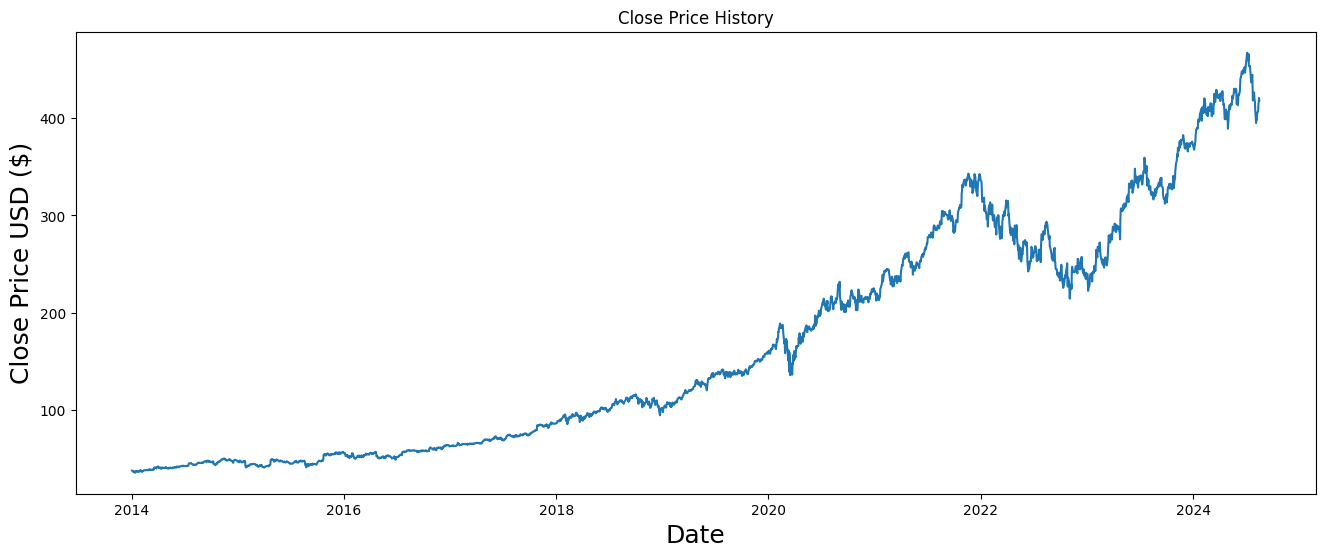

In [24]:
# Show the data
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [25]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
dataset = data.values

In [26]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.95))
print(f"Training data length: {training_data_len}")


Training data length: 2541


In [27]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [28]:
# Create the training data set
train_data = scaled_data[:training_data_len, :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)   


In [29]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [32]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)  # Increased epochs for better training

Epoch 1/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 9.8700e-04
Epoch 2/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - loss: 3.3601e-04
Epoch 3/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 2.0997e-04
Epoch 4/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 2.1829e-04
Epoch 5/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 2.2006e-04
Epoch 6/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 1.7631e-04
Epoch 7/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 2.4076e-04
Epoch 8/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 1.6031e-04
Epoch 9/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 83s 19ms/step - loss: 1.6741e-04
Epoch 10/10
2481/2481 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 1.7629e-04


In [33]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [34]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


In [35]:
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")

RMSE: 11.362815375643285


C:\Users\Manoj\AppData\Local\Temp\ipykernel_9212\2770638779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


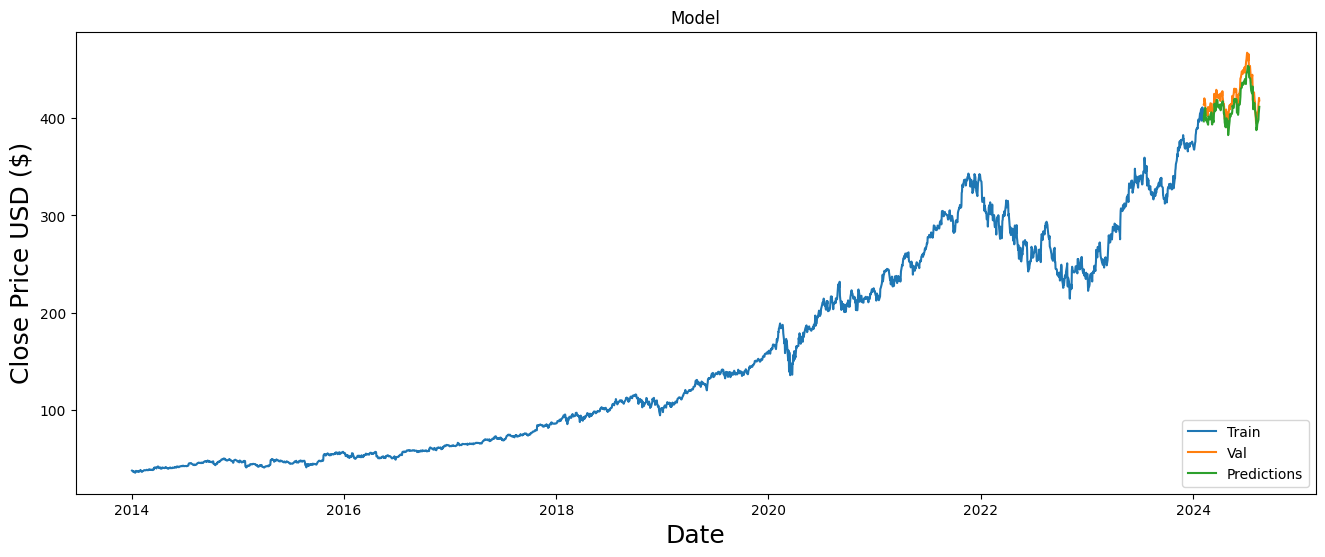

In [36]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [37]:
# Show the valid and predicted prices
print(valid)


                 Close  Predictions
Date                               
2024-02-07  414.049988   396.862885
2024-02-08  414.109985   404.157562
2024-02-09  420.549988   404.768555
2024-02-12  415.260010   410.716400
2024-02-13  406.320007   406.363037
...                ...          ...
2024-08-12  406.809998   397.225159
2024-08-13  414.010010   398.405731
2024-08-14  416.859985   404.906342
2024-08-15  421.029999   407.842346
2024-08-16  418.470001   411.809479

[133 rows x 2 columns]
